<a href="https://colab.research.google.com/github/SKR-01/LLM_FineTuning_Transformers/blob/main/Efficient_FineTuning_Llama2_7b_Ludwig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Llama2 For Code-Generation**
Input example, if we prompt the model with this instruction:

```
Instruction: Create an array of length 5 which contains all even numbers between 1 and 10.
```

Output response:

```
Response: array = [2, 4, 6, 8, 10]
```



In [2]:
!pip uninstall -y tensorflow --quiet
!pip install ludwig
!pip install ludwig[llm]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 13.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 12.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=d1c10337a369d8efef31d6863b2341c5f2a8fcdc58a58c5829f95ff50ec02891
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [3]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [4]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


### **Importing The Code Generation Dataset**



In [5]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = pd.read_json("https://raw.githubusercontent.com/sahil280114/codealpaca/master/data/code_alpaca_20k.json")

# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

# For this webinar, we will just 500 rows of this dataset.
df = df.head(n=1000)

## **Preview The Code Alpaca Dataset**




In [6]:
df.head(10)

,instruction,input,output,split
0,Create an array of length 5 which contains all...,,"arr = [2, 4, 6, 8, 10]",0
1,Formulate an equation to calculate the height ...,,Height of triangle = opposite side length * si...,0
2,Write a replace method for a string class whic...,"string = ""Hello World!""\nreplace_with = ""Greet...","def replace(self, replace_with):\n new_stri...",0
3,Create an array of length 15 containing number...,,"arr = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33...",0
4,Write a function to find the number of distinc...,"matrix = [[1, 0, 0],\n [1, 0, 1],\n ...",def find_num_distinct_states(matrix):\n sta...,0
5,Create a nested loop to print every combinatio...,,for i in range(10):\n for j in range(10):\n...,0
6,Write a function to find the maximum differenc...,"arr = [5, 3, 17, 11, 9]",def max_difference(arr):\n max_diff = 0\n ...,0
7,Write a function to generate the nth Fibonacci...,< noinput >,def fib(n):\n if n == 0:\n return 0\...,0
8,Write a class to represent a 2D point with x a...,,"class Point:\n def __init__(self, x, y):\n ...",0
9,Write code that removes spaces from a given st...,"string = "" A B C D ""","def remove_spaces(string): \n return """".joi...",0


In [7]:
num_self_sufficient = (df['input'] == '').sum()
num_need_context = df.shape[0] - num_self_sufficient

# We are only using 100 rows of this dataset for this webinar
print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_context/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 1000
% of examples that are self-sufficient: 47.2
% of examples that are need additional context: 52.8


Average number of tokens in the instruction column: 23
Average number of tokens in the input column: 8
Average number of tokens in the output column: 65



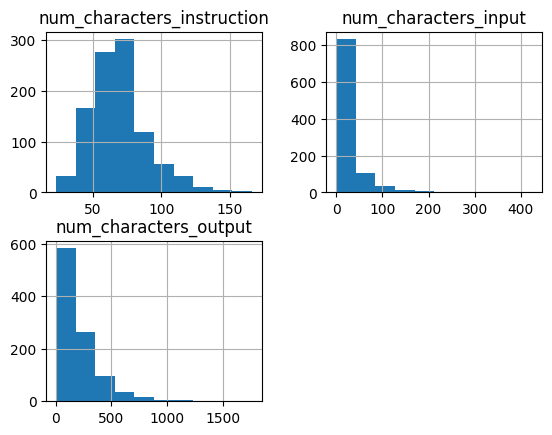

In [8]:
# Calculating the length of each cell in each column
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_input'] = df['input'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

In [10]:
qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: huggyllama/llama-7b

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 1
    - 0
    - 0

trainer:
  type: finetune
  epochs: 1
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer


INFO:ludwig.features.text_feature:Max length of feature 'None': 220 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 222 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 222 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
INFO:ludwig.features.text_feature:Max length of feature 'output': 580 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 582 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 582 for feature 'output'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
INFO:ludwig.data.preprocessing:Building dataset: DONE
INFO:ludwig.data.cache.manager:Writing preprocessed training set cache to /con

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.pri

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 1000 step(s), approximately 1 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 5000 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training: 100%|█████████▉| 999/1000 [10:53<00:00,  1.59it/s, loss=0.00352]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training: 100%|██████████| 1000/1000 [10:54<00:00,  1.52it/s, loss=0.0257]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1000, epoch: 1
INFO:ludwig.trainers.trainer:Evaluation took 0.2534s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════╕
│                       │      train │ validation   │ test   │
╞═══════════════════════╪════════════╪══════════════╪════════╡
│ bleu                  │     0.0476 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ char_error_rate       │     3.9565 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ loss                  │     0.4118 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ next_token_perplexity │ 14164.8584 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ perplexity            │ 31961.9395 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ rouge1_fmea

Training: 100%|██████████| 1000/1000 [10:55<00:00,  1.53it/s, loss=0.0257]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ FINISHED │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


#### Perform Inference

In [11]:
test_examples = pd.DataFrame([
      {
            "instruction": "Create an array of length 5 which contains all even numbers between 1 and 10.",
            "input": ''
      },
      {
            "instruction": "Create an array of length 15 containing numbers divisible by 3 up to 45.",
            "input": "",
      },
      {
            "instruction": "Create a nested loop to print every combination of numbers between 0-9",
            "input": ""
      },
      {
            "instruction": "Generate a function that computes the sum of the numbers in a given list",
            "input": "",
      },
      {
            "instruction": "Create a class to store student names, ages and grades.",
            "input": "",
      },
      {
            "instruction": "Print out the values in the following dictionary.",
            "input": "my_dict = {\n  'name': 'John Doe',\n  'age': 32,\n  'city': 'New York'\n}",
      },
])

predictions = model.predict(test_examples)[0]
for input_with_prediction in zip(test_examples['instruction'], test_examples['input'], predictions['output_response']):
  print(f"Instruction: {input_with_prediction[0]}")
  print(f"Input: {input_with_prediction[1]}")
  print(f"Generated Output: {input_with_prediction[2][0]}")
  print("\n\n")

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.33.3"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: create an array of length 5 which contains all even numbers between 1 and 10.
### input: 
### response:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that provides f

Prediction: 100%|██████████| 1/1 [00:21<00:00, 21.87s/it]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer


Instruction: Create an array of length 5 which contains all even numbers between 1 and 10.
Input: 
Generated Output: [2, 4, 6, 8, 10]



Instruction: Create an array of length 15 containing numbers divisible by 3 up to 45.
Input: 
Generated Output: [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45]



Instruction: Create a nested loop to print every combination of numbers between 0-9
Input: 
Generated Output: for i in range(10):
    for j in range(10):
        print(i, j)



Instruction: Generate a function that computes the sum of the numbers in a given list
Input: 
Generated Output: def sum_list(list):
    return sum(list)



Instruction: Create a class to store student names, ages and grades.
Input: 
Generated Output: class student:
    def __init__(self, name, age, grade):
        self.name = name
        self.age = age
        self.grade = grade



Instruction: Print out the values in the following dictionary.
Input: my_dict = {
  'name': 'John Doe',
  'age': 32,
  'city': 

/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [33]:
!ludwig upload hf_hub --repo_id SKR-01/Replica_Llama_CodeBase --model_path /content/results/api_experiment_run

adapter_model.bin: 100% 16.8M/16.8M [00:04<00:00, 4.17MB/s]
Model uploaded to `https://huggingface.co/SKR-01/Replica_Llama_CodeBase/tree/main/` with repository name `SKR-01/Replica_Llama_CodeBase`
